In [51]:
import matplotlib.pyplot as plt
import scipy.signal as signal
import json
from lib.Recording import Recording

Loaded data from file that does not contain labels.
Please mute this message by setting mute=True in your algorithm submission


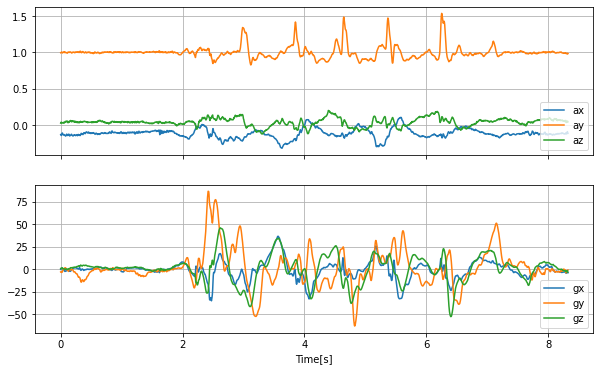

In [52]:
filename = '../recordings/5_steps.json'
trace = Recording(filename, no_labels = True, mute = True)
trace.plot([['ax', 'ay', 'az'], ['gx', 'gy', 'gz']])

In [53]:
ax_list = list(zip(trace.data["ax"].timestamps, trace.data["ax"].values))
ay_list = list(zip(trace.data["ay"].timestamps, trace.data["ay"].values))
az_list = list(zip(trace.data["az"].timestamps, trace.data["az"].values))

In [54]:
# veeeeeeery rough walk detection algorithm, mostly based on empirical observations... 
# Just take ay, subtract 1 and calculate the resulting signal's energy over 1 second windows
# will absolutely break in some way, don't judge me when it does
energy_by_interval = [0.0]
window_start_time = ax_list[0][0]
window_length = 1
for i in range(len(ax_list)):
    #_, ax = ax_list[i]
    time, ay = ay_list[i]
    #_, az = az_list[i]
    ay -= 1
    power = ay*ay
    if time-window_length > window_start_time:
        energy_by_interval.append(power)
        window_start_time = time
    else:
        energy_by_interval[-1] += power
print(energy_by_interval)

[0.006986793818011109, 0.017286478129544414, 1.2254572762179008, 2.9553567359368147, 3.4144974748386385, 2.858054269494262, 3.536850020688557, 0.24677877351007452, 0.004726235161627702]


In [55]:
#signal.find_peaks(trace.data["ay"].values)